  <h1 style="color: brown;">1. Introduction</h1>

<div style="background-color: #F5F5DC; border: 2px solid #8b4513; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif; box-shadow: 3px 3px 15px rgba(0, 0, 0, 0.1);">

  <p>In deep learning, the number of training epochs plays a crucial role in determining the performance of a model. This task focuses on determining whether increasing the number of training epochs can improve the accuracy of the worst-performing case from the previous experiment, where noise was systematically added to the XOR dataset. The worst performance was observed when the noise standard deviation was set to 0.5, resulting in a test accuracy of 72%. </p>

  <p>To support this investigation, the model is trained for 200, 500, 800, and 1100 epochs, and the results are compared. Any improvements or lack thereof are discussed, along with plausible reasons for these outcomes. As in the previous experiment, the MLP model consists of a single hidden layer with four nodes and is trained using the Stochastic Gradient Descent (SGD) optimizer with a learning rate of 0.1. Binary cross-entropy with logits (BCEWithLogitsLoss) is used as the loss function, and the Tanh activation function is applied to the hidden layer. The training dataset consists of 2,500 samples, and the test dataset includes 500 samples.</p>

</div>


  <h1 style="color: brown;">2. Importing Libraries</h1> 

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
torch.manual_seed(88)

  <h1 style="color: brown;">3. XOR Dataset Class Implementation</h1> 

In [2]:
class XOR_Dataset(torch.utils.data.Dataset):
    # Defining the constructor of the XOR_Dataset class, which initializes the dataset with a given size and standard deviation (std).
    def __init__(self, size, std=0.5):  # Default std is set to 0.5
        # Calling the parent class constructor (super() refers to the Dataset class from torch.utils.data)
        super().__init__()
        # Storing the size and std as class attributes
        self.size = size
        self.std = std
        # Calling the function to generate the XOR data with noise
        self.generate_cont_xor()

    # Defining a method to generate XOR data points with added Gaussian noise
    def generate_cont_xor(self):
        # Randomly generating pairs of binary values (0 or 1) of shape (size, 2)
        self.data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        # Creating labels based on the XOR logic, where the sum of the pair equals 1 (i.e., one of the values is 1 and the other is 0)
        self.label = (self.data.sum(dim=1) == 1).to(torch.float32).unsqueeze(1)
        # Adding Gaussian noise to the data points based on the provided standard deviation
        self.data += self.std * torch.randn(self.data.shape)

    # Defining a method to return the total number of data points in the dataset
    def __len__(self):
        # Returning the size of the dataset
        return self.size

    # Defining a method to retrieve a specific data point and its corresponding label
    def __getitem__(self, idx):
        # Returning the data point at index 'idx' and its associated label
        return self.data[idx], self.label[idx]

  <h1 style="color: brown;">4. XOR Classifier Model Implementation</h1>

In [3]:
class XOR_Classifier(nn.Module):
    # Defining the constructor of the XOR_Classifier class, which initializes the neural network architecture.
    def __init__(self, num_inputs, num_hidden, num_outputs):
        # Calling the parent class constructor (super() refers to the nn.Module class from torch.nn)
        super().__init__()
        # Creating the first linear layer (input layer), which connects 'num_inputs' features to 'num_hidden' neurons
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        # Defining the activation function (Tanh) to introduce non-linearity into the model
        self.activation = nn.Tanh()
        # Creating the second linear layer (output layer), which connects 'num_hidden' neurons to 'num_outputs' features
        self.linear2 = nn.Linear(num_hidden, num_outputs)
        
    # Defining the forward pass of the network (i.e., how data moves through the network)
    def forward(self, x):
        # Passing the input 'x' through the first linear layer
        x = self.linear1(x)
        # Applying the Tanh activation function to the output of the first layer
        x = self.activation(x)
        # Passing the activated output through the second linear layer (producing the final output)
        return self.linear2(x)

  <h1 style="color: brown;">5. XOR Classifier Training and Testing</h1> 

In [4]:
# List of epoch values to experiment with
epoch_variations = [200, 500, 800, 1100]

# Defining the function to train the model with varied epochs and return accuracies
def train_model_with_varied_epochs(epoch_list):
    # Initializing lists to store training and testing accuracies for each epoch count
    train_accuracies = []
    test_accuracies = []

    # Looping through each epoch count from the provided list
    for epochs in epoch_list:
        # Creating the training and testing datasets with std=0.5 (default in XOR_Dataset)
        train_dataset = XOR_Dataset(size=2500)
        test_dataset = XOR_Dataset(size=500)
        # Creating DataLoaders to load the data in batches
        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

        # Initializing the XOR classifier model with 2 inputs, 4 hidden units, and 1 output
        model = XOR_Classifier(num_inputs=2, num_hidden=4, num_outputs=1)
        # Defining the loss function as binary cross entropy with logits
        loss_module = nn.BCEWithLogitsLoss()
        # Defining the optimizer as stochastic gradient descent (SGD) with a learning rate of 0.1
        optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

        # Entering the training loop for the specified number of epochs
        model.train()  # Setting the model to training mode
        for epoch in tqdm(range(epochs), desc=f'Training for {epochs} epochs', leave=True):
            # Looping through the training data in batches
            for data, label in train_loader:
                optimizer.zero_grad()  # Clearing the previous gradients
                output = model(data)  # Performing a forward pass through the model
                loss = loss_module(output, label)  # Calculating the loss
                loss.backward()  # Performing backpropagation to compute gradients
                optimizer.step()  # Updating the model weights

        # After training, computing training and test accuracies
        train_acc = compute_accuracy(train_loader, model)  # Calculating training accuracy
        test_acc = compute_accuracy(test_loader, model)  # Calculating testing accuracy
        
        # Appending the results to the accuracy lists
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        # Printing the accuracy results for the current epoch count
        print(f'Epochs: {epochs}, Training Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')

    # Returning the lists of training and testing accuracies
    return train_accuracies, test_accuracies

# Defining a function to compute the accuracy of the model
def compute_accuracy(loader, model):
    correct = 0  # Initializing counter for correct predictions
    total = 0  # Initializing counter for total predictions
    model.eval()  # Setting the model to evaluation mode (disables gradient calculation)
    with torch.no_grad():  # Disabling gradient calculation for the accuracy evaluation
        for data, label in loader:
            output = model(data)  # Performing a forward pass to get the model's predictions
            predicted = (torch.sigmoid(output) > 0.5).float()  # Converting logits to binary predictions
            total += label.size(0)  # Counting total number of labels
            correct += (predicted == label).sum().item()  # Counting correctly predicted labels
    return 100 * correct / total  # Returning accuracy as a percentage

# Running the training function and storing the accuracies in global variables
train_accuracies, test_accuracies = train_model_with_varied_epochs(epoch_variations)

Training for 200 epochs: 100%|███████████████████████████████████████████████████████| 200/200 [00:07<00:00, 26.54it/s]


Epochs: 200, Training Accuracy: 71.32%, Test Accuracy: 75.60%


Training for 500 epochs: 100%|███████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.38it/s]


Epochs: 500, Training Accuracy: 73.76%, Test Accuracy: 72.80%


Training for 800 epochs: 100%|███████████████████████████████████████████████████████| 800/800 [00:29<00:00, 26.76it/s]


Epochs: 800, Training Accuracy: 72.12%, Test Accuracy: 72.80%


Training for 1100 epochs: 100%|████████████████████████████████████████████████████| 1100/1100 [00:40<00:00, 26.95it/s]

Epochs: 1100, Training Accuracy: 74.44%, Test Accuracy: 74.80%


  <h1 style="color: brown;">6. Visualization</h1> 

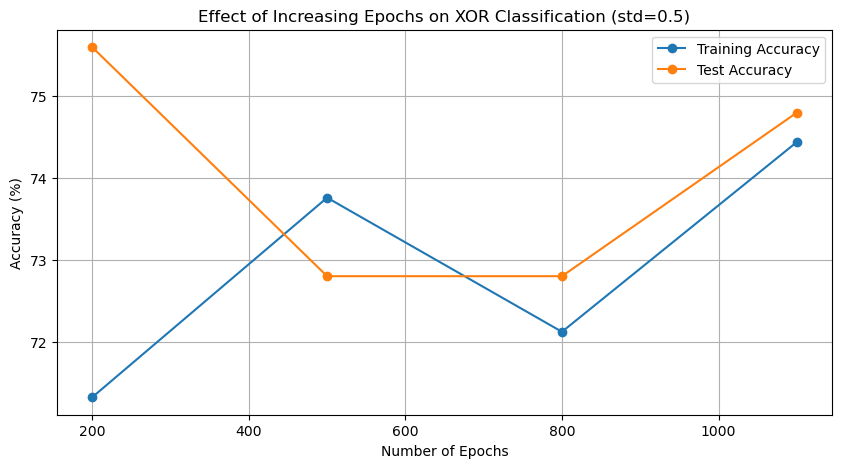

In [5]:
# Creating a new figure with a specific size for better visualization
plt.figure(figsize=(10, 5))

# Plotting the training accuracies over different epoch values
plt.plot(epoch_variations, train_accuracies, label='Training Accuracy', marker='o')
# Plotting the test accuracies over different epoch values
plt.plot(epoch_variations, test_accuracies, label='Test Accuracy', marker='o')

# Setting the title for the plot, indicating the purpose of the experiment
plt.title('Effect of Increasing Epochs on XOR Classification (std=0.5)')

# Adding labels to the x-axis (Number of Epochs) and y-axis (Accuracy in %)
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy (%)')

# Adding a legend to differentiate between the training and test accuracy lines
plt.legend()

# Adding grid lines to the plot for better readability
plt.grid(True)

# Displaying the plot on the screen
plt.show()

  <h1 style="color: brown;">7. Results</h1> 

<div style="background-color: #F5F5DC; border: 2px solid #8b4513; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif; box-shadow: 3px 3px 15px rgba(0, 0, 0, 0.1);">
  
  <p style="font-size: 16px; color: #333;">The table below shows the training and test accuracies of the XOR classifier trained on the dataset with the highest noise level, using increasing numbers of epochs.</p>

  <table style="width:100%; border-collapse: collapse; margin: 10px 0; font-size: 16px; color: #333;">
    <tr style="background-color: #8b4513; color: white;">
      <th style="padding: 8px; border: 2px solid black;">Epochs</th>
      <th style="padding: 8px; border: 2px solid black;">Training Accuracy (%)</th>
      <th style="padding: 8px; border: 2px solid black;">Test Accuracy (%)</th>
    </tr>
    <tr>
      <td style="padding: 8px; border: 2px solid black; background-color: #F7F0DB;">200</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #F7F0DB;">71.32</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #F7F0DB;">75.60</td>
    </tr>
    <tr>
      <td style="padding: 8px; border: 2px solid black; background-color: #EADAB8;">500</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #EADAB8;">73.76</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #EADAB8;">72.80</td>
    </tr>
    <tr>
      <td style="padding: 8px; border: 2px solid black; background-color: #F7F0DB;">800</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #F7F0DB;">72.12</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #F7F0DB;">72.80</td>
    </tr>
    <tr>
      <td style="padding: 8px; border: 2px solid black; background-color: #EADAB8;">1100</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #EADAB8;">74.44</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #EADAB8;">74.80</td>
    </tr>
  </table>

</div>


<h2 style="color: brown;">7.1 Interpretation of Results</h2>

<div style="background-color: #F5F5DC; border: 2px solid #8b4513; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif; box-shadow: 3px 3px 15px rgba(0, 0, 0, 0.1);">

  <p><strong>Initial Improvement with More Epochs:</strong></p>
  <p>Training the model for 200 epochs results in a test accuracy of 75.60%, which is higher than the baseline test accuracy of 72% obtained in the original experiment with 100 epochs. This suggests that increasing the number of epochs initially helps the model adapt to the noisy data and learn a better representation of the XOR problem. However, the training accuracy remains relatively low at 71.32%, indicating that the model is still struggling to capture the noise-influenced data despite improving on the test set.</p>

  <p><strong>Diminishing Returns with Extended Training:</strong></p>
  <p>Training the model for 500 and 800 epochs shows diminishing improvements. At 500 epochs, the training accuracy increases slightly to 73.76%, but the test accuracy drops back down to 72.80%. This plateau in test performance, despite longer training, suggests that the model has already reached its learning capacity for the given noisy data. Even at 800 epochs, the test accuracy remains stable at 72.80%, while the training accuracy decreases slightly to 72.12%. This indicates that further training does not help the model generalize better and may even introduce slight overfitting, as seen in the reduced training accuracy.</p>

  <p><strong>Slight Improvement at 1100 Epochs:</strong></p>
  <p>At 1100 epochs, the training accuracy rises to 74.44%, and the test accuracy increases slightly to 74.80%. This suggests that while more training can lead to marginal improvements, the effect is not substantial, and the model's performance remains limited by the noise in the data.</p>

</div>


<h2 style="color: brown;">7.2 Plausible Reasons for Changes in Accuracy</h2> 

<div style="background-color: #F5F5DC; border: 2px solid #8b4513; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif; box-shadow: 3px 3px 15px rgba(0, 0, 0, 0.1);">

  <p><strong>Effect of Noise on Learning:</strong></p>
  The XOR problem with a standard deviation of 0.5 introduces a significant amount of noise, which blurs the boundaries between the two classes. The model's performance is constrained by this noise, making it harder to achieve high accuracy even with prolonged training. This explains why the test accuracy plateaus around 72–75%, regardless of increasing epochs.</p>

  <p><strong>Overfitting Risk:</strong></p>
As the number of epochs increases, there is a risk of the model overfitting to the noisy training data. This is evident in the fluctuation of training accuracy across different epoch counts. While the test accuracy improves slightly, it remains relatively stable after 500 epochs, indicating that further training provides diminishing returns and may cause the model to memorize noise rather than learn useful patterns.</p>

  <p><strong>Capacity of the Model:</strong><p>The MLP model with a single hidden layer and four neurons has limited capacity, which may restrict its ability to effectively learn from noisy data, even with extended training. The small improvements at 1100 epochs suggest that the model is reaching the limits of what it can learn from the noisy XOR dataset.</p>

</div>


<h2 style="color: brown;">8. Conclusion</h1>

<div style="background-color: #F5F5DC; border: 2px solid #8b4513; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif; box-shadow: 3px 3px 15px rgba(0, 0, 0, 0.1);">
  
  <p>In conclusion, increasing the number of training epochs from 200 to 1100 results in only minor improvements in accuracy, with the most notable gains occurring between 200 and 500 epochs. After 500 epochs, the test accuracy stabilizes. The results suggest that while additional epochs can help improve accuracy to some extent, the impact of noise in the data limits the model's ability to achieve significantly better results. The evidence indicates that merely increasing the number of epochs beyond a certain point does not provide substantial benefits in this high-noise environment.</p>
  
</div>
